In [3]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from keras.utils import pad_sequences
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import keras

sns.set()

## Alternate 1: Network Structure Change 

In [4]:
# Expects: run the code on lstm_traffic_only_1 to generate the csv info

traffic_df = pd.read_csv("../data/traffic_pre_lstm.csv")
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])
traffic_df.set_index('timestamp', inplace=True)
traffic_df.head()

,610,611,612,613,614,615,616,617,618,619,...,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,16.0,20.0,21.0,50.0,19.0,48.0,34.0,0.0,65.0,32.000000
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,69.0,34.0,0.0,69.0,32.000000
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,70.0,36.0,0.0,67.0,28.000000
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,37.0,21.0,57.0,22.0,56.0,46.0,0.0,58.0,28.000000
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,23.0,14.0,57.0,22.0,51.0,46.0,0.0,60.0,27.666667


In [5]:
traffic_df.shape

(29984, 449)

In [6]:
training_sample = traffic_df[100:20000]
validation_sample = traffic_df[20001:]

In [ ]:
def create_sequence_training_set(training_sample, seq_length, pred_horizon, input_features, output_features):
    seq_arrays = []
    seq_labs = []
    
    for i in range(training_sample.shape[0] - seq_length - pred_horizon):
        seq_arrays.append(
            training_sample.iloc[i:seq_length+i, :input_features].to_numpy())
        seq_labs.append(
            training_sample.iloc[seq_length+pred_horizon+i, :output_features])

    seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)
    return seq_arrays, seq_labs

# create validation dataset


def create_validation_set(validation_sample, seq_length, pred_horizon, input_features, output_features):
    val_arrays = []
    val_labs = []
    for i in range(validation_sample.shape[0] - seq_length - pred_horizon):
        if i < seq_length:
            val_arrays.append(
                validation_sample.iloc[:(i+1), :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[:(
                i+pred_horizon+1), :output_features].to_numpy()[-1])
        else:
            val_arrays.append(
                validation_sample.iloc[i:seq_length+i, :input_features].to_numpy())
            val_labs.append(
                validation_sample.iloc[seq_length+i+pred_horizon, :output_features])

    val_arrays = pad_sequences(
        val_arrays, padding='pre', dtype=object).astype(np.float32)
    val_labs = np.array(val_labs, dtype=object).astype(np.float32)
    return val_arrays, val_labs

In [ ]:

# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 449, inclusive
features = 449

sensor = pd.Series(training_sample.columns).sample(
    features, replace=False).sort_values().to_list()

print(sensor)

seq_arrays, seq_labs = create_sequence_training_set(
    training_sample, seq_length, ph, features, features)

['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '650', '651', '652', '653', '654', '655', '656', '657', '658', '659', '660', '661', '662', '663', '664', '665', '666', '667', '668', '669', '670', '671', '672', '673', '674', '675', '676', '677', '678', '679', '680', '681', '682', '683', '684', '6

In [ ]:
val_arrays, val_labs = create_validation_set(
    validation_sample, seq_length, ph, input_features=features, output_features=features)

In [10]:
def train_lstm_model(model_path, seq_length, seq_arrays, seq_labs, input_features, output_features):
# define path to save model
    model_path = model_path

    # build the network
    output_size = output_features

    model = Sequential()

    model.add(LSTM(
        input_shape=(seq_length, input_features), 
        units=100, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))

    model.add(LSTM(units=64, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))
    model.add(LSTM( units=32, activation="relu", return_sequences=False))
    model.add(Dense(units=output_size, activation="linear"))

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

    print(model.summary())

    # fit the network
    history = model.fit(seq_arrays,
                    seq_labs,
                    epochs=1000,
                    batch_size=80,
                    validation_split=0.05,
                    verbose=2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.1,
                            patience=5,
                            verbose=0,
                            mode='min'),
                        keras.callbacks.ModelCheckpoint(
                            model_path,
                            monitor='val_loss',
                            save_best_only=True,
                            mode='min',
                            verbose=0)
                    ])

    return model, history



In [11]:
model, history = train_lstm_model('lstm_traffic_alternative_structure.keras', 
                                  seq_length,
                                  seq_arrays,
                                  seq_labs, 
                                  input_features=features, 
                                  output_features=features)
# list all data in history
print(history.history.keys())

/opt/anaconda3/envs/usd_ai/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 100)        │       220,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 449)            │        14,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,473 (1.10 MB)

 Trainable params: 289,473 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
237/237 - 10s - 43ms/step - loss: 1377.2416 - mse: 1377.2416 - val_loss: 264.3505 - val_mse: 264.3505
Epoch 2/1000
237/237 - 7s - 30ms/step - loss: 213.8821 - mse: 213.8821 - val_loss: 235.6627 - val_mse: 235.6627
Epoch 3/1000
237/237 - 7s - 30ms/step - loss: 185.3443 - mse: 185.3443 - val_loss: 231.7558 - val_mse: 231.7558
Epoch 4/1000
237/237 - 8s - 32ms/step - loss: 179.2327 - mse: 179.2327 - val_loss: 228.1116 - val_mse: 228.1116
Epoch 5/1000
237/237 - 7s - 31ms/step - loss: 176.0238 - mse: 176.0238 - val_loss: 223.0773 - val_mse: 223.0773
Epoch 6/1000
237/237 - 8s - 36ms/step - loss: 173.9614 - mse: 173.9614 - val_loss: 194.6079 - val_mse: 194.6079
Epoch 7/1000
237/237 - 10s - 42ms/step - loss: 166.9861 - mse: 166.9861 - val_loss: 194.4071 - val_mse: 194.4071
Epoch 8/1000
237/237 - 9s - 37ms/step - loss: 165.3799 - mse: 165.3799 - val_loss: 197.5547 - val_mse: 197.5547
Epoch 9/1000
237/237 - 8s - 33ms/step - loss: 165.1982 - mse: 165.1982 - val_loss: 189.0972 - v

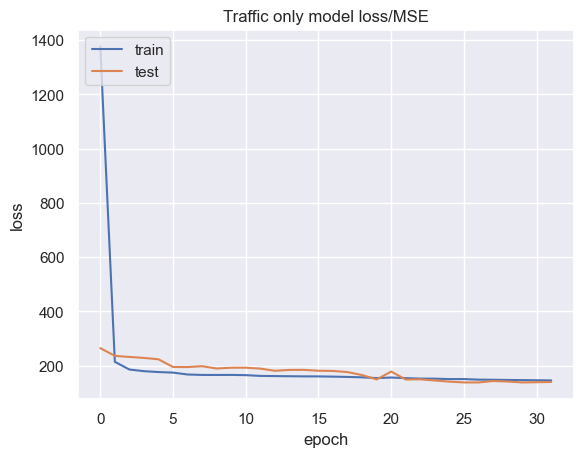

In [12]:
# summarize history for Loss/MSE
def summarize_history_loss(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

summarize_history_loss(history, 'Traffic only model loss/MSE')

In [13]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

312/312 - 3s - 11ms/step - loss: 173.5132 - mse: 173.5132

MSE: 173.51324462890625


312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


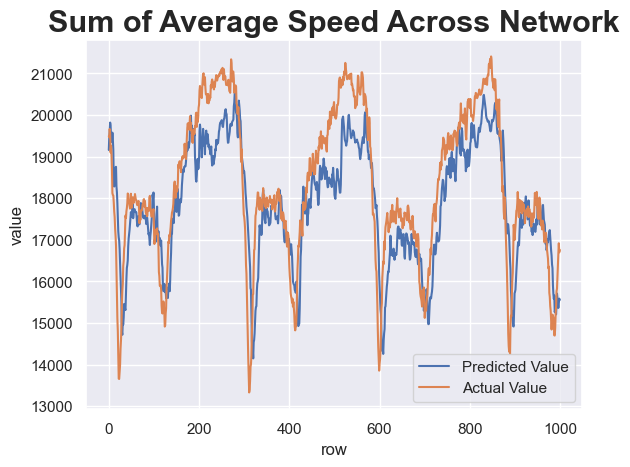

In [14]:
def plot_prediction_across_network(model, val_arrays, val_labs, title):
    y_pred_test = model.predict(val_arrays)
    y_true_test = val_labs

    # aggregating for easier visualization
    y_pred_dv = [row.sum() for row in y_pred_test]
    y_true_dv = [row.sum() for row in y_true_test]

    start = 5000
    ts = 1000

    plt.plot(y_pred_dv[start:start+ts], label='Predicted Value')
    plt.plot(y_true_dv[start:start+ts], label='Actual Value')
    plt.title(title,
            fontsize=22, fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend()
    plt.show()

plot_prediction_across_network(model, val_arrays, val_labs, 'Sum of Average Speed Across Network')